In [ ]:
!pip install neptune

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
from PIL import ImageFile
import os, json, pandas as pd
from fastai.vision.all import *
import matplotlib.pyplot as plt
import torch

from torchvision.models import resnet50, vgg16, vgg19, googlenet, alexnet
import neptune

In [ ]:
DATASET_DIR = "/kaggle/input/wildlife-trap-images/balanced_dataset_split/balanced_dataset_split"  
JSON_PATH = "/kaggle/input/wildlife-trap-images/train_test_split.json"  
OUTPUT_DIR = "/kaggle/working/model_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ImageFile.LOAD_TRUNCATED_IMAGES = True


with open(JSON_PATH, "r") as f:
    split_data = json.load(f)


df_train = pd.DataFrame(split_data["train"])
df_test = pd.DataFrame(split_data["test"])


df_train["image_path"] = df_train["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))
df_test["image_path"] = df_test["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))


print(f"Trainingsdaten: {len(df_train)} Bilder, Testdaten: {len(df_test)} Bilder")
print(df_train.head())

✅ Trainingsdaten: 7981 Bilder, Testdaten: 2012 Bilder
                                                       file_path  \
0  train/acinonyx jubatus/acinonyx jubatus_20110222-PICT6562.JPG   
1  train/acinonyx jubatus/acinonyx jubatus_20140107-PICT0076.JPG   
2  train/acinonyx jubatus/acinonyx jubatus_20140307-PICT0220.JPG   
3  train/acinonyx jubatus/acinonyx jubatus_20140307-PICT0222.JPG   
4  train/acinonyx jubatus/acinonyx jubatus_20140307-PICT0223.JPG   

              label  \
0  acinonyx jubatus   
1  acinonyx jubatus   
2  acinonyx jubatus   
3  acinonyx jubatus   
4  acinonyx jubatus   

                                                                                                                                       image_path  
0  /kaggle/input/wildlife-trap-images/balanced_dataset_split/balanced_dataset_split/train/acinonyx jubatus/acinonyx jubatus_20110222-PICT6562.JPG  
1  /kaggle/input/wildlife-trap-images/balanced_dataset_split/balanced_dataset_split/train/acinonyx jub

In [4]:
# Ensure at least one image per category in df_train_sampled
min_per_category = 2
df_train_sampled = df_train.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), min_per_category), random_state=42)
).reset_index(drop=True)

# Fill up to 100 samples if more data is available
remaining_samples = 100 - len(df_train_sampled)
if remaining_samples > 0:
    df_remaining = df_train[~df_train.index.isin(df_train_sampled.index)]
    if len(df_remaining) >= remaining_samples:  # Ensure we have enough samples
        df_train_sampled = pd.concat([df_train_sampled, df_remaining.sample(n=remaining_samples, random_state=42)])
    else:
        df_train_sampled = pd.concat([df_train_sampled, df_remaining])  # Take all remaining samples

# Ensure at least one image per category in df_test_sampled
df_test_sampled = df_test.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 1), random_state=42)
).reset_index(drop=True)

# Vokabular aus Labels erstellen
vocab = df_train["label"].unique().tolist()
#vocab = df_train_sampled["label"].unique().tolist()

<ipython-input-4-074d93e8a60e>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_sampled = df_train.groupby('label', group_keys=False).apply(
<ipython-input-4-074d93e8a60e>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_sampled = df_test.groupby('label', group_keys=False).apply(


Train set size: 6385
Validation set size: 1596


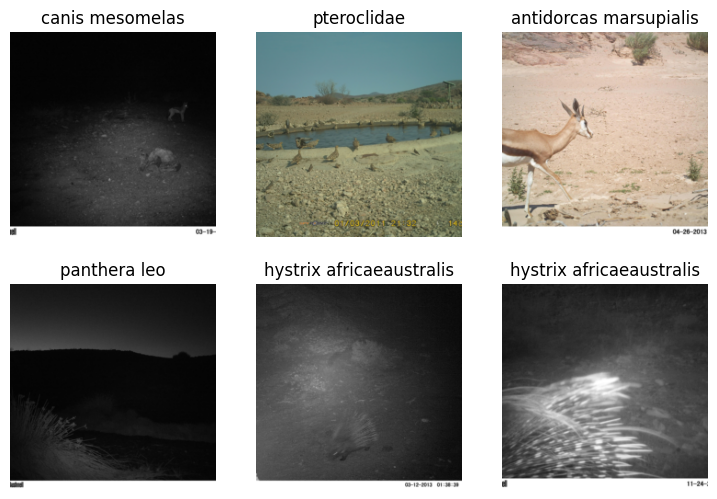

In [ ]:
# DataBlock für Training definieren
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 20% als Validierung
    item_tfms=Resize(224),
)
#dls = dblock.dataloaders(df_train_sampled, bs=8, num_workers=8, device="cuda")
dls = dblock.dataloaders(df_train, bs=8, num_workers=8, device="cuda")
dls.show_batch(max_n=6)

# Test DataLoader erstellen 
#test_dl = dls.test_dl(df_test_sampled, device="cuda", with_labels=True)
test_dl = dls.test_dl(df_test, device="cuda", with_labels=True)

print(f"Train set size: {len(dls.train_ds)}")
print(f"Validation set size: {len(dls.valid_ds)}")


In [ ]:
# Neptune.ai initialisieren
run = neptune.init_run(
    project="insert_your_project_here",  #  durch Projekt ersetzen
    api_token="insert_your_api_token_here",  #  durch API-Token ersetzen
    tags=["googlenet"]
)

# Logge allgemeine Parameter
run["global/parameters"] = {
    "dataset_dir": DATASET_DIR,
    "json_path": JSON_PATH,
    "batch_size": 16,
    "epochs": 100,
}

models_to_eval = {
    #"resnet50": resnet50, 
    #"vgg16": vgg16, 
    #"vgg19": vgg19,
    #"alexnet": alexnet,
    "googlenet": googlenet
}

config = {"epochs": 100}

results = {}  # Hier speichern wir die Testgenauigkeiten der Modelle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-69


In [ ]:
# Schleife über die Modelle 
for name, arch in models_to_eval.items():
    try:
        print(f"\n=== Training und Evaluation für {name} ===")
        run[f"{name}/start"] = "Training gestartet"

        if name == "googlenet":
            model_instance = arch(pretrained=True).to(device)
            body = create_body(model_instance, cut=-1)
            nf = num_features_model(body)
            head = create_head(nf, dls.c)
            model = nn.Sequential(body, head).to(device)
            learn = Learner(dls, model, metrics=accuracy,
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
        else:
            learn = vision_learner(dls, arch, metrics=accuracy,
                           cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]).to_fp16()

        # Neptune: Modellarchitektur speichern
        run[f"{name}/model_summary"] = str(learn.model)

        # Lernrate suchen und loggen
        lr_find_results = learn.lr_find(start_lr=1e-6, end_lr=1e-2, show_plot=False)
        optimal_lr = lr_find_results.valley
        print(f"{name}: empfohlene Lernrate = {optimal_lr}")
        run[f"{name}/optimal_lr"] = optimal_lr

        
        # Training starten 
        learn.fit_one_cycle(config["epochs"], lr_max=optimal_lr)
        
        # Train-Loss pro Epoche loggen
        for epoch, loss in enumerate(learn.recorder.losses):
            run[f"{name}/train_loss"].append(loss.item())  # Neptune speichert als Chart
        
        # Validation-Loss & Accuracy pro Epoche loggen
        if hasattr(learn.recorder, "values") and len(learn.recorder.values) > 0:
            for epoch, values in enumerate(learn.recorder.values):
                if len(values) > 1:  # Falls Valid-Loss existiert
                    run[f"{name}/valid_loss"].append(values[1])
                if len(values) > 2:  # Falls Accuracy existiert
                    run[f"{name}/accuracy"].append(values[2])

        # Neptune-Logging überprüfen
        print(f"Logging abgeschlossen für {name}.")


        # Early Stopping nach dem Training etnfernen
        for cb in learn.cbs:
            if isinstance(cb, EarlyStoppingCallback):
                learn.remove_cb(cb)

        # Test Evaluation
        test_loss, test_acc = learn.validate(dl=test_dl)
        print(f"{name}: Testgenauigkeit = {test_acc:.4f}")
        results[name] = test_acc
        run[f"{name}/test_accuracy"] = test_acc

        # Confusion Matrix speichern
        interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
        interp.plot_confusion_matrix(figsize=(8,8), dpi=60)
        plt.title(f"Confusion Matrix: {name}")
        cm_path = os.path.join(OUTPUT_DIR, f"cm_{name}.png")
        plt.savefig(cm_path)
        plt.close()
        run[f"{name}/confusion_matrix"].upload(cm_path)

        # Modell speichern
        model_path = os.path.join(OUTPUT_DIR, f"model_{name}.pkl")
        learn.export(model_path)
        print(f"{name} gespeichert unter: {model_path}")
        run[f"{name}/model_checkpoint"].upload(model_path)

    except Exception as e: 
        print(f"Fehler in {name}: {e}")
        run[f"{name}/error"] = str(e)


=== Training und Evaluation für googlenet ===


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 199MB/s]


googlenet: empfohlene Lernrate = 0.0006918309954926372


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,2.300077,1.829299,0.560150,07:13
1,1.640513,1.306457,0.663534,07:00
2,1.420659,1.015795,0.728697,06:59
3,1.065681,0.858697,0.768797,06:55
4,0.852884,0.772574,0.788847,06:56
5,0.765619,0.736885,0.817043,06:54
6,0.774234,0.691112,0.810150,06:49
7,0.866464,0.757932,0.804511,06:50
8,0.788182,0.739581,0.800752,06:49
9,0.781505,0.840422,0.777569,06:48


No improvement since epoch 6: early stopping
✅ Logging abgeschlossen für googlenet.


googlenet: Testgenauigkeit = 0.7838


googlenet gespeichert unter: /kaggle/working/model_outputs/model_googlenet.pkl


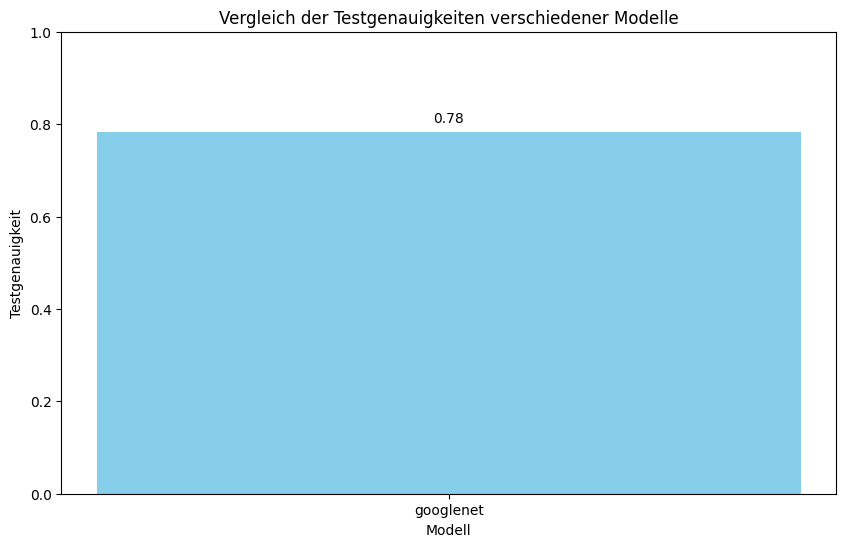

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-69/metadata


In [ ]:
# Modellvergleich: Testgenauigkeiten visualisieren
model_names = list(results.keys())
accuracies = [results[m] for m in model_names]

plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel("Modell")
plt.ylabel("Testgenauigkeit")
plt.title("Vergleich der Testgenauigkeiten verschiedener Modelle")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')

comparison_plot = os.path.join(OUTPUT_DIR, "model_comparison.png")
plt.savefig(comparison_plot)
plt.show()
run["global/model_comparison"].upload(comparison_plot)

# Neptune Run beenden
run.stop()